# Experiment 2: Better Features

Following experiment 1, we now want to try to find better features. This will take inspiration from existing research done at Stanford. We will derive the same features and attempt to replicate the same benchmark as them. [Paper here](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwjf1Pbo6ZveAhUKBsAKHbeSAicQFjAAegQIBhAC&url=http%3A%2F%2Fcs229.stanford.edu%2Fproj2017%2Ffinal-reports%2F5229663.pdf&usg=AOvVaw1SAoqP8hAkRiRJH9lwmeEn)

This notebook has been heavily unit tested, and as a result a lot of code has been removed from the notebook itself. I have demonstrated as much as possible through importing units and running them on example values.

First the same setup as Experiment 1:

In [25]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from protos import review_set_pb2, review_pb2
review_set = review_set_pb2.ReviewSet()
with open("../../data/normalizedData/yelpNYC", 'rb') as f:
  review_set.ParseFromString(f.read())

In [6]:
from exp2_feature_extraction import find_words
from sklearn.utils import shuffle

num_each_class = 8141
reviews = shuffle(review_set.reviews)

i = 0
fake_reviews = []
for x in reviews:
  if i == num_each_class:
    break
  if x.label:
    fake_reviews.append(x)
    i+=1

i = 0
genuine_reviews = []
for x in reviews:
  if i == num_each_class:
    break
  if x.label == False:
    fake_reviews.append(x)
    i+=1
    
all_reviews = [(x, find_words(x.review_content)) for x in shuffle(fake_reviews + genuine_reviews)]

In [7]:
print(len(all_reviews))

16282


In [17]:
targets = [x[0].label for x in all_reviews]

Our first features will be the structural features. These are:
* Length of the review
* Average word length
* Number of sentences
* Average sentence length
* Percentage of numerals
* Percentage of capitalized words:

In [8]:
from exp2_feature_extraction import structural_features

review = review_pb2.Review()
review.review_content = "1 very horrible restaurant. Eat 10 Starbucks instead."
structural_features((review, ["1", "very", "horrible", "restaurant", "Eat", "10", "Starbucks", "instead"]))

(53, 5.5, 2, 26.0, 0.25, 0.25)

In [9]:
def get_means(features):
  return [np.mean(np.array([x for x in features])[:,i]) for i in range(len(features[0]))]

In [10]:
def get_probs(model, means, independent, r=1000, d=1):
  probs = []
  to_predicts = []
  for i in range(r):
    to_predict = [x for x in means]
    to_predict[independent] = i/d
    to_predicts.append(to_predict)
  return model.predict_proba(to_predicts)[:,1], r/d

In [30]:
def plot_probs(probabilitieswithr, xlabel, l=0, u=None):
  probabilities = probabilitieswithr[0]
  r = probabilitieswithr[1]
  plt.plot(probabilities)
  plt.ylabel('Probability of Deception')
  plt.xlabel(xlabel)
  plt.axis([l, r if u is None else u, 0, 1])

In [15]:
features_structural = [structural_features(x) for x in all_reviews]

In [33]:
naive_bayes = MultinomialNB()
fit_data = naive_bayes.fit(features_structural, targets)

structural_means = get_means(features_structural)
r_values = [1100, 9, 15, 150, 100, 130]
d_values = [1, 1, 1, 1, 10000, 1000]
structural_probs = [get_probs(naive_bayes, structural_means, i, r_values[i], d_values[i]) for i in range(len(structural_means))]

In [28]:
structural_means

[552.4224910944602,
 4.28541944330971,
 7.479732219629038,
 70.94158740476084,
 0.005785369658706944,
 0.1370068344613422]

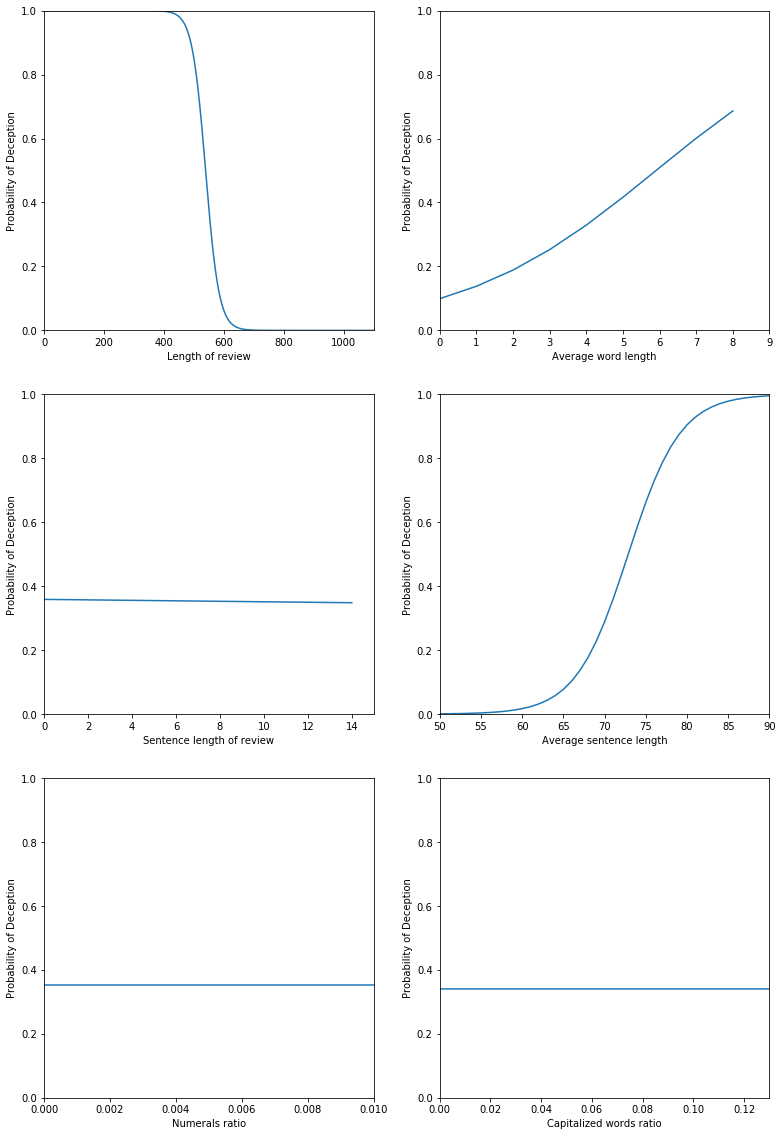

In [35]:
plt.rcParams['figure.figsize'] = [13, 20]
structural_names = ["Length of review", "Average word length", "Sentence length of review", "Average sentence length",
                    "Numerals ratio", "Capitalized words ratio"]

l_values = [0, 0, 0, 50, 0, 0]
u_values = [None, None, None, 90, None, None]
for i in range(6):
  plt.subplot(3, 2, i+1)
  plot_probs(structural_probs[i], structural_names[i], l_values[i], u_values[i])

This tells us that of our structural features, the most indicative are length of review, average word length and average sentence length. In this case the following observations are noted:
* As the length of the review increases, the probability of deception decreases strongly.
* A lack of long words indicates genuity. This may correlate with the increasing length of review.
* Longer sentences, over 75 words indicate deception. This may be the result of a lack of punctuation. Intuition would indicate this is a mistake made by Naive Bayes.

As we see later these features do not provide an increase in accuracy. It is likely Naive Bayes creates some simplifications here which are detrimental for us.

And then the Part of Speech features. There are 36 part of speech categories. Descriptions can be found [here](https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b)

In [6]:
import nltk
from exp2_feature_extraction import pos_features

sample_pos_features = pos_features(["Dog", "and", "beautiful"], nltk)
[(i, str(sample_pos_features[i])) for i in range(0, len(sample_pos_features)) if sample_pos_features[i] > 0]

[(5, '0.3333333333333333'),
 (11, '0.3333333333333333'),
 (35, '0.3333333333333333')]

In [305]:
naive_bayes = MultinomialNB()
fit_data = naive_bayes.fit([x for x in features_pos], targets)

pos_means = get_means(features_pos)
pos_probs = [get_probs(naive_bayes, pos_means, i, 10, 100) for i in range(len(pos_means))]

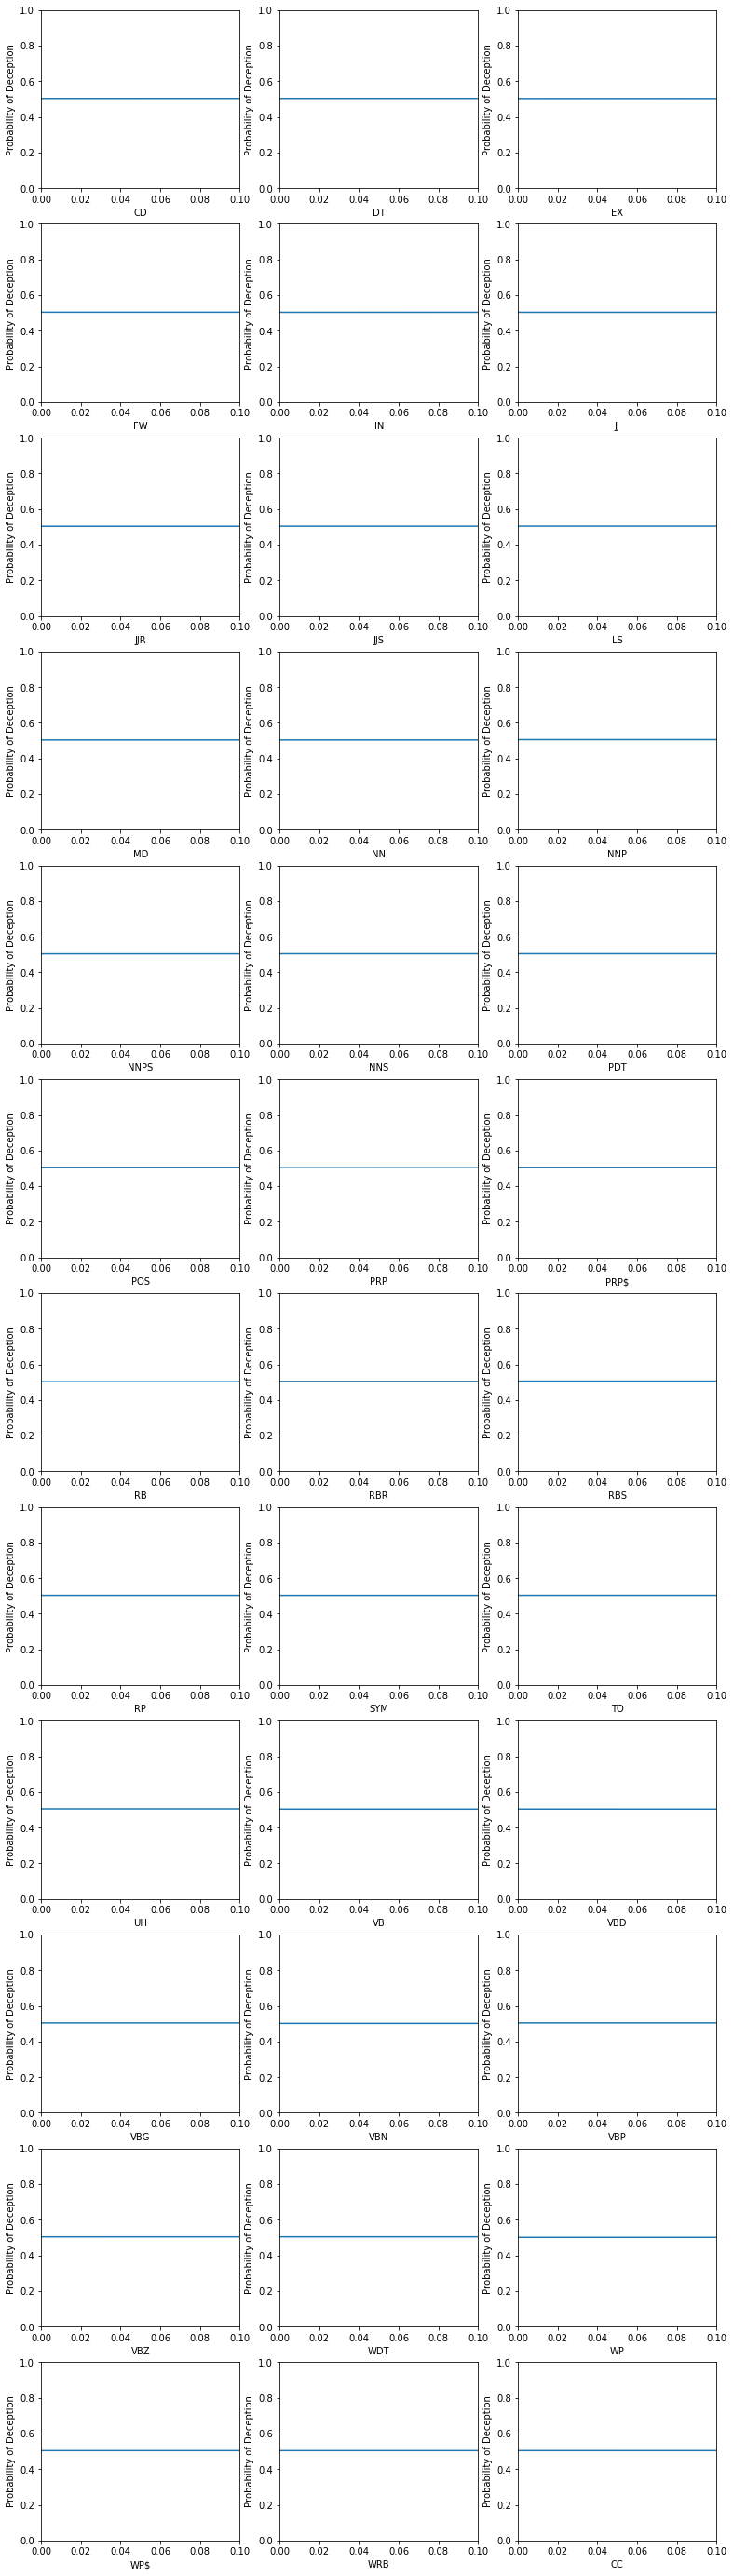

In [306]:
plt.rcParams['figure.figsize'] = [13, 50]
pos_names = ["CD", "DT", "EX", "FW", "IN", "JJ", "JJR",
    "JJS", "LS", "MD", "NN", "NNP", "NNPS", "NNS",
    "PDT", "POS", "PRP", "PRP$", "RB", "RBR", "RBS",
    "RP", "SYM", "TO", "UH", "VB", "VBD", "VBG",
    "VBN", "VBP", "VBZ", "WDT", "WP", "WP$", "WRB", "CC"]
for i in range(36):
  plt.subplot(12, 3, i+1)
  plot_probs(pos_probs[i], pos_names[i])

Here 5 is JJ, which is for adjective. This represents "beautiful" in the input. 11 is NNP, which is proper noun, which represents "Dog". 35 is CC which is coordinating conjuction, which is "and". These are given as percentages, where each here is one third.

In [7]:
features_pos = [pos_features(x[1], nltk) for x in all_reviews]

Next are sentiment features. These will be:
* Percentage of words that have positive sentiment
* Percentage of words that have negative sentiment

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()
print("Scores:")
print("none:", sentiment_analyzer.polarity_scores("none")["compound"])
print("good:", sentiment_analyzer.polarity_scores("good")["compound"])
print("bad:", sentiment_analyzer.polarity_scores("bad")["compound"])

from exp2_feature_extraction import sentiment_features
sentiment_features(["good", "good", "none", "bad"], sentiment_analyzer)

Scores:
none: 0.0
good: 0.4404
bad: -0.5423


/home/stefan/anaconda3/envs/lucas/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


(0.5, 0.25)

In [9]:
features_sentiment = [sentiment_features(x[1], sentiment_analyzer) for x in all_reviews]

In [343]:
naive_bayes = MultinomialNB()
fit_data = naive_bayes.fit([x for x in features_sentiment], targets)

sentiment_means = get_means(features_sentiment)
sentiment_probs = get_probs(naive_bayes, sentiment_means, 0, 100, 10)

In [344]:
sentiment_means

[0.09898460067011156, 0.016237614736895913]

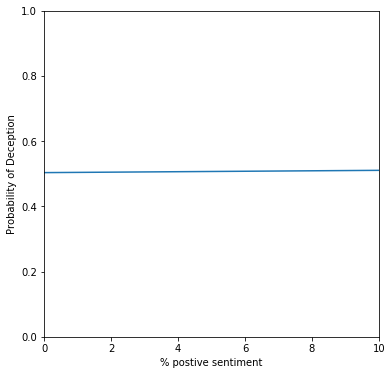

In [351]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.subplot(1, 1, 1)
plot_probs(sentiment_probs, "% postive sentiment")
plt.show()

Next the topic model features from LDA

We will perform some data cleaning, which will improve our results when generating LDA topics. This cleaning is stemming and lemmatization, removing words with three or less characters, and removing stopwords.

### Stemming and Lemmatization

Stemming will reduce a word to a 'stem' form, which can be used to normalise words that mean the same thing. For example 'cleanly' and 'cleanest' would be stemmed to 'clean'. Lemmatization uses a vocabulary and morphological analysis to more intelligently normalise words, for example 'car' and 'automobile' could go to 'vehicle'

In [10]:
from exp2_feature_extraction import preprocess_words
preprocess_words(["I", "was", "gonna", "just", "stay", "in", "for", "coffee", "but", "this", "little", "store", "happily", "surprised", "me"])

['gonna', 'stay', 'coffe', 'littl', 'store', 'happili', 'surpris']

In [11]:
import gensim

def get_topic_features_maker(reviews, num_topics=100, bigrams=False):
  preprocessed_words = [preprocess_words(x[1], bigrams=bigrams) for x in reviews]
  
  dictionary = gensim.corpora.Dictionary(preprocessed_words)
  dictionary.filter_extremes(no_below=15, no_above=0.33, keep_n=100000)
  bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_words]
  lda_model = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2)
    
  def make_topic_features(review_words):
    topics = lda_model.get_document_topics(dictionary.doc2bow(preprocess_words(review_words, bigrams=bigrams)))
    return topic_features(topics, num_topics)

  def get_terms(topic_id):
    return [dictionary.id2token[x[0]] + " " + str(x[1]) for x in lda_model.get_topic_terms(topic_id, 5)]
  return (make_topic_features, get_terms)

In [12]:
topic_features_maker, get_topic_terms = get_topic_features_maker(all_reviews)

/home/stefan/anaconda3/envs/lucas/lib/python3.7/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [13]:
def print_topic_terms(term_frequencies, term_getter):
  for topic_id in range(0, len(term_frequencies)):
    if term_frequencies[topic_id] > 0:
      print("----- Topic", topic_id)
      print("\n".join(term_getter(topic_id)))

In [14]:
from exp2_feature_extraction import topic_features

words = ["Pizza", "Pasta", "Ramen", "Noodles"]
tf = topic_features_maker(words)
print_topic_terms(tf, get_topic_terms)

----- Topic 19
pizza 0.21524006
crust 0.04352088
chees 0.024899844
sauc 0.019861035
top 0.018330967
----- Topic 88
pasta 0.12399301
vegetarian 0.032519918
dish 0.029265996
ravioli 0.021183636
delici 0.020061402
----- Topic 97
ramen 0.21542433
broth 0.07984852
noodl 0.04758751
ippudo 0.047039736
wait 0.041843496


In [15]:
features_unigram_topic = [topic_features_maker(x[1]) for x in all_reviews]

In [16]:
bigram_topic_features_maker, get_topic_terms = get_topic_features_maker(all_reviews, bigrams=True)

In [17]:
words = ["Fried", "Chicken", "Pizza", "Slice"]
tf2 = bigram_topic_features_maker(words)
print_topic_terms(tf2, get_topic_terms)

----- Topic 12
fri chicken 0.18048993
bloodi mari 0.10303593
comfort food 0.060871754
time love 0.056455065
pomm frite 0.04096748
----- Topic 74
place order 0.13034548
dessert good 0.06687016
bone marrow 0.062271353
recommend friend 0.05877991
lobster roll 0.050766602


In [18]:
features_bigram_topic = [bigram_topic_features_maker(x[1]) for x in all_reviews]

Now we will find the reviewer features. This includes:
* The maximum number of reviews in a day
* Average review length
* Standard deviation of reviewer's ratings
* Percentage of positive review ratings
* Percentage of negative review ratings

In [19]:
from exp2_feature_extraction import reviewer_features

review1 = review_pb2.Review()
review1.review_content="1234"
review1.date="2018-11-12"
review1.rating=2

review2 = review_pb2.Review()
review2.review_content="12345678"
review2.date="2018-11-12"
review2.rating=4

user_id = 1234
reviewer_map = {
    user_id: [review1, review2]
}

reviewer_features(user_id, reviewer_map)

(2, 6.0, 1.4142135623730951, 0.5, 0.5)

In [226]:
means = get_means(features_reviewer)

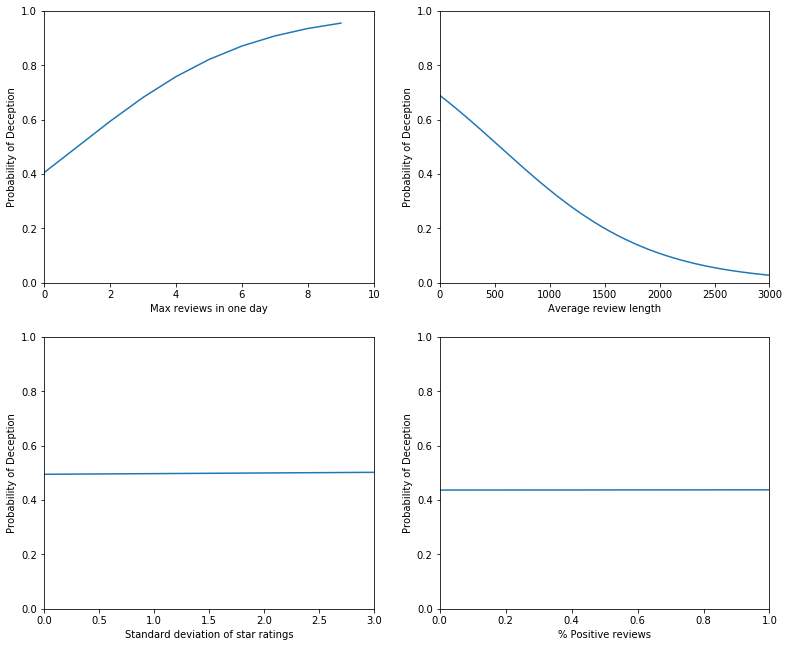

In [273]:
plt.rcParams['figure.figsize'] = [13, 11]
plt.subplot(2, 2, 1)
plot_probs(get_probs(naive_bayes, means, 0, 10), "Max reviews in one day")
plt.subplot(2, 2, 2)
plot_probs(get_probs(naive_bayes, means, 1, 3000), "Average review length")
plt.subplot(2, 2, 3)
plot_probs(get_probs(naive_bayes, means, 2, 300, 100), "Standard deviation of star ratings") 
plt.subplot(2, 2, 4)
plot_probs(get_probs(naive_bayes, means, 3, 100, 100), "% Positive reviews") 
plt.show()

The most separable features are max reviews in one day, where more reviews in a day becomes a very strong indicator of fake reviews, and average length of review, where longer reviews are much more likely to be genuine.

The standard deviation of a user's rating and the percentage of positive reviews is not very informative in this case. It is likely that Naive Bayes is not capable of finding the meaning behind these features

As shown, our first feature is the number of reviews on this day (2), the average review length (6.0), the standard devation of our ratings (1.41...), percentage of positive review ratings (0.5) and percentage of negative review ratings (0.5)

In [20]:
from exp2_feature_extraction import reviews_by_reviewer
reviews_reviewer_map = reviews_by_reviewer([x[0] for x in all_reviews])
features_reviewer = [reviewer_features(x[0].user_id, reviews_reviewer_map) for x in all_reviews]

Now we put our features together:

In [21]:
from scipy.sparse import coo_matrix, hstack
predictor_features = hstack([coo_matrix(features_structural), coo_matrix(features_sentiment),
                             coo_matrix(features_pos), coo_matrix(features_unigram_topic),
                             coo_matrix(features_bigram_topic), coo_matrix(features_reviewer)])

In [377]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(predictor_features.toarray())
data2D = pca.transform(predictor_features.toarray())

In [378]:
from sklearn.preprocessing import normalize
nData2D = normalize(data2D, axis=0) + 1
sData2D = data2D+5000

In [380]:
cnb.fit(sData2D, targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
cnb = MultinomialNB()

In [24]:
from sklearn.model_selection import cross_validate
cross_validate(cnb, predictor_features, targets, cv=5, return_train_score=False)

{'fit_time': array([0.01517105, 0.01427197, 0.01396346, 0.01411963, 0.01473594]),
 'score_time': array([0.00193429, 0.00168014, 0.00157595, 0.00183821, 0.00153089]),
 'test_score': array([0.58870473, 0.60380835, 0.59090909, 0.60534398, 0.61179361])}

In [392]:
import numpy as np
x_min, x_max = sData2D[:,0].min()-1000, sData2D[:,0].max()+1000
y_min, y_max = sData2D[:,1].min()-1000, sData2D[:,1].max()+1000
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))

Z = cnb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape) 

In [393]:
def subplot_classifications(subplot_number, title, colour, data, xx, yy, Z, label,
                            indices=None, rows=2):
    if indices == None:
        indices = random.sample(range(0, data2D.shape[0]), 5000)
    plt.subplot(rows, 2, subplot_number)

    plt.contourf(xx, yy, Z, colors=['#a3ffa9', '#ffa3a3', 'black'], extend="both")
    for i in indices:
        if targets[i] == label:
            plt.scatter(data[i,0], data[i,1], c=colour, marker='+')
    plt.contour(xx, yy, Z)
    plt.title(title)
    plt.axis('on')

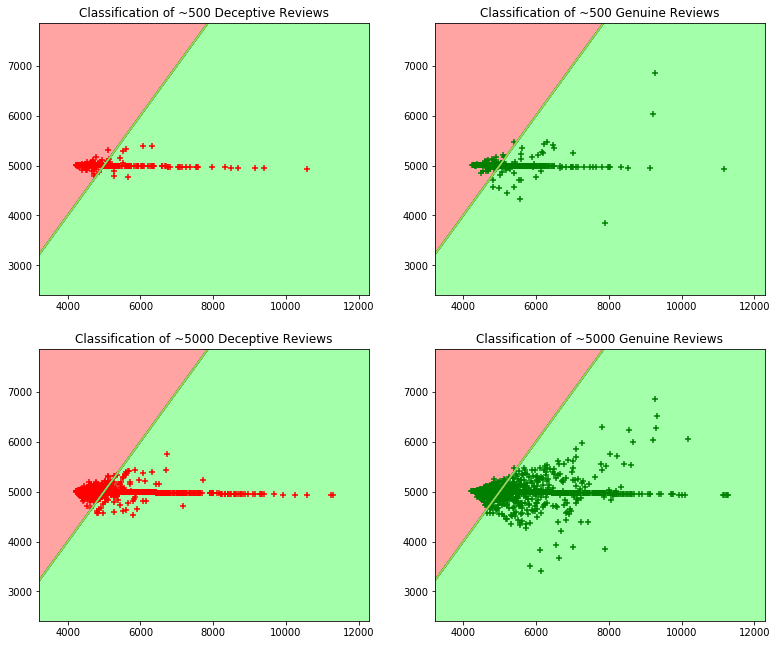

In [394]:
import random
plt.rcParams['figure.figsize'] = [13, 11]
indices1000 = random.sample(range(0, sData2D.shape[0]), 1000)
indices10000 = random.sample(range(0, sData2D.shape[0]), 10000)
subplot_classifications(1, "Classification of ~500 Deceptive Reviews", "r", sData2D, xx, yy, Z, label=1, indices=indices1000)
subplot_classifications(2, "Classification of ~500 Genuine Reviews", "g", sData2D, xx, yy, Z, label=0, indices=indices1000)
subplot_classifications(3, "Classification of ~5000 Deceptive Reviews", "r", sData2D, xx, yy, Z, label=1, indices=indices10000)
subplot_classifications(4, "Classification of ~5000 Genuine Reviews", "g", sData2D, xx, yy, Z, label=0, indices=indices10000)
plt.show()

I do not seem to be able to replicate the results from the paper. Adding more topics for bigrams/unigrams seems to have virtually no difference. Using bigrams alone for lda topics seems to improve by 0.01. By joining unigrams and bigrams to be modelled by the same LDA we get about - 0.005.

Based on the paper, the possible differences are:

* Structural features - all very clear, difficult to get wrong
* POS Percentages - perhaps another POS tagger could improve results. We are using one from nltk, but there are alternatives
* Semantic features - perhaps another Semantic tagger could improve results, but it's hard to imagine it being that much better at tagging
* Unigram / Bigram features - It's not very obvious exactly what they're doing. Maybe a better LDA topic modeller could be used? The paper claims that high accuracy can be obtained through just unigrams and bigrams, so this could be tried too.
* Reviewer features - all very clear, difficult to get this wrong.

Let's try with just Unigrams/Bigrams to see how accurate we are:

In [25]:
def avg_accuracy(features):
  predictor_features = hstack([coo_matrix(x) for x in features])
  naive_bayes = MultinomialNB()
  fold = 5
  results = cross_validate(naive_bayes, predictor_features, targets, cv=fold, return_train_score=False)
  return sum([x for x in results['test_score']])/fold

In [26]:
print("ngrams only:", avg_accuracy([features_unigram_topic, features_bigram_topic]))

ngrams only: 0.6099995399719156


Out of interest, let's try training with only our other features to see how predictive they are alone:

In [27]:
print("POS tags only:  ", avg_accuracy([features_pos]))
print("Structural only:", avg_accuracy([features_structural]))
print("Sentiment only: ", avg_accuracy([features_sentiment]))
print("Reviewer only:  ", avg_accuracy([features_reviewer]))

POS tags only:   0.5674998454003978
Structural only: 0.5959359158254186
Sentiment only:  0.5315682206566186
Reviewer only:   0.6227137358352828


In [55]:
avg_review_lens = [[x[1]] for x in features_reviewer]

In [266]:
naive_bayes = MultinomialNB()
fit_data = naive_bayes.fit([x for x in features_reviewer], targets)

In [113]:
import numpy as np
np.exp(naive_bayes.feature_log_prob_)

array([[1.52677933e-03, 9.97131288e-01, 2.09768640e-05, 1.20114833e-03,
        1.19807634e-04],
       [2.23658842e-03, 9.95680445e-01, 5.45360352e-05, 1.66526187e-03,
        3.63168812e-04]])

In [114]:
naive_bayes.score(features_reviewer, targets)

0.612

Interesting, our structural features have pretty wild trends!

It appears as though our best predicting features are the reviewer features and ngrams. Let's try combining them. To avoid swamping the reviewer features, we will reduce our topics to a small number, 10 each.

In [28]:
unigram_topic_features_predictive_maker, get_topic_terms = get_topic_features_maker(all_reviews, num_topics=10)
features_unigram_topic_predictive = [unigram_topic_features_predictive_maker(x[1]) for x in all_reviews]

bigram_topic_features_predictive_maker, get_topic_terms = get_topic_features_maker(all_reviews, num_topics=10,
                                                                                   bigrams=True)
features_bigram_topic_predictive = [bigram_topic_features_maker(x[1]) for x in all_reviews]

In [29]:
avg_accuracy([features_reviewer, features_unigram_topic_predictive, features_bigram_topic_predictive])

0.6249246609743847

However, it seems to be better to use only unigram topics:

In [30]:
print("unigrams without bigrams:", avg_accuracy([features_reviewer, features_unigram_topic]))
print("bigrams without unigrams:", avg_accuracy([features_reviewer, features_bigram_topic]))

unigrams without bigrams: 0.6280563964265621
bigrams without unigrams: 0.6251705874634051


And a smaller number of topics (like we have in the predictive feature sets) actually decreases the accuracy for unigrams:

In [31]:
print("unigrams without bigrams:", avg_accuracy([features_reviewer, features_unigram_topic_predictive]))
print("bigrams without unigrams:", avg_accuracy([features_reviewer, features_bigram_topic_predictive]))

unigrams without bigrams: 0.6274427491278319
bigrams without unigrams: 0.6252319748176102


Let's try forgetting about LDA topic models and try using bag of words to generate our features.

In [32]:
corpus = [x[0].review_content for x in all_reviews]

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
unigram_count_vect = CountVectorizer()
features_ngram_bow = unigram_count_vect.fit_transform(corpus)

In [34]:
features = [features_reviewer for i in range(0, 4)]
features.append(features_ngram_bow)
avg_accuracy(features)

0.67018818165227

It turns out that bag of words is unexpectedly accurate. Oddly TFIDF is less accurate than Bag of words.

Bag of words is not supposed to be good for classifying reviews. Is it the case that those 'non-interesting' words like 'the', 'a', 'is', etc are in some way predictive that someone is faking their opinion?

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

features = [features_sentiment for i in range(0, 9)]
features_ngram_tfidf = tfidf_transformer.fit_transform(features_ngram_bow)
features.append(features_ngram_tfidf)
avg_accuracy(features)

0.64721913023018

Also trying this with HashingVectorizer, again we get a lower accuracy than bag of words:

In [36]:
from sklearn.feature_extraction.text import HashingVectorizer
hashing_vectorizer = HashingVectorizer(n_features=9950, non_negative=True)

features_ngram_hash = hashing_vectorizer.fit_transform(corpus)
avg_accuracy([features_pos, features_pos, features_ngram_hash])

/home/stefan/anaconda3/envs/lucas/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/stefan/anaconda3/envs/lucas/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


0.6536679698281909

From this experiment it appears that we should not attempt to reproduce the results of the mentioned paper. It should also be very easy to use more data than the paper used. The data source used by the paper has more genuine and fake reviews available, so we can train with more data.

We can see that reviewer centric data is helpful in classifying fake or genuine. There is space here for adding new features, and this could be a good way to improve accuracy.